In [ ]:
pip install mysql-connector-python matplotlib prettytable

                    Main Menu                     
1. View Total Sales and Quantity Summary
2. View Total Purchase Report
3. Search by Customer Name
4. Exit

         Total Sales and Quantity Summary         

Total Price by Category:
+---------------+-------------+----------------+----------------+----------------+
| Category Name | Total Price | Total Quantity | Average Price  | Percentage (%) |
+---------------+-------------+----------------+----------------+----------------+
|   Furniture   |  127181.00  |      945       | 140.1732683704 |   29.474023    |
|    Clothing   |  139054.00  |      3516      | 39.9388767418  |   32.225575    |
|  Electronics  |  165267.00  |      1154      | 148.3409684968 |   38.300402    |
+---------------+-------------+----------------+----------------+----------------+

Total Price by SubCategory:
+------------------+-------------+----------------+----------------+----------------+
| SubCategory Name | Total Price | Total Quantity | Average Price  | 

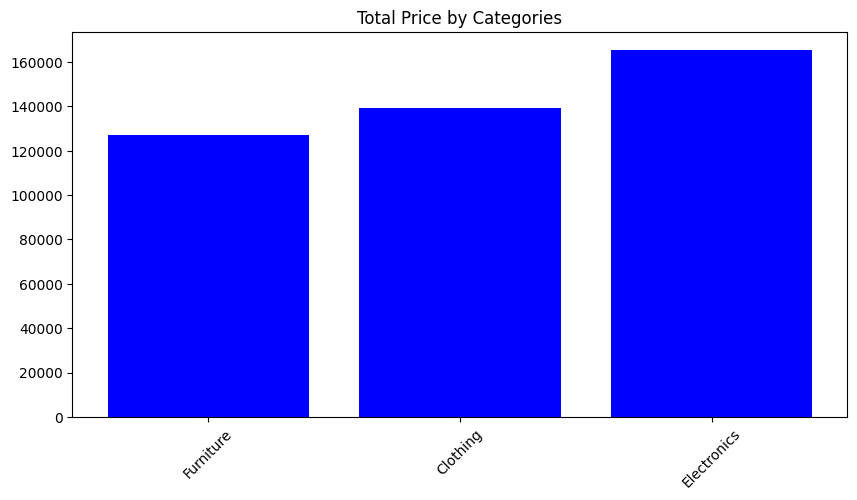

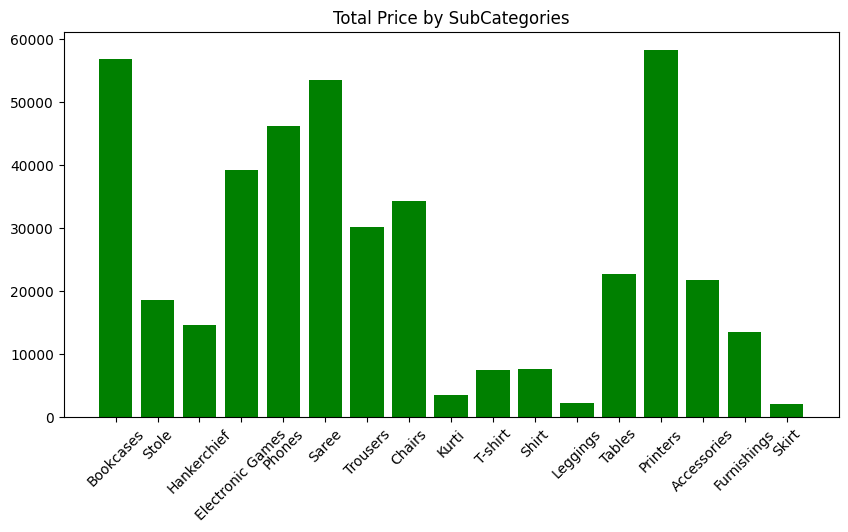

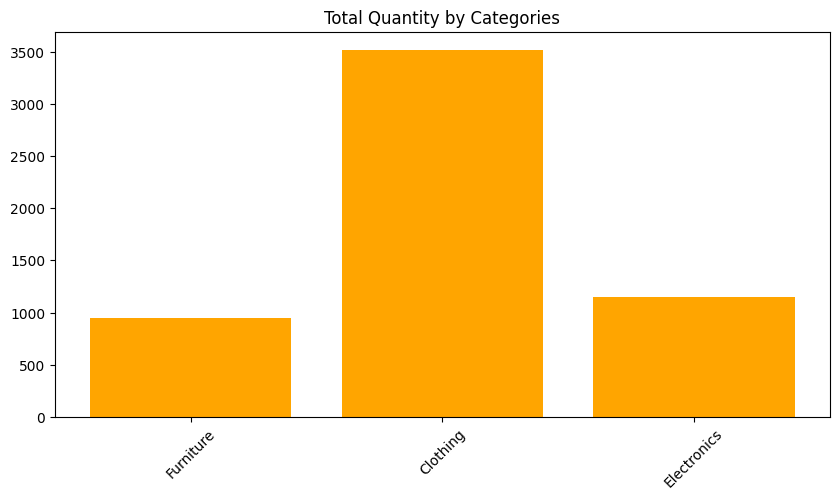

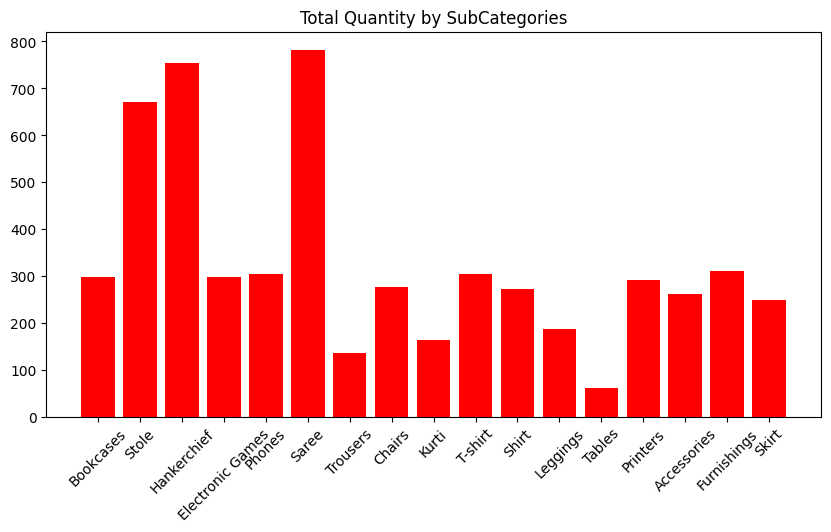

                    Main Menu                     
1. View Total Sales and Quantity Summary
2. View Total Purchase Report
3. Search by Customer Name
4. Exit

              Total Purchase Report               
Total Amount: 431502.00
Total Quantity: 5615

+---------------+----------+------------+---------+----------+-------------+------------------+
| Customer Name | Order ID | Order Date |  Amount | Quantity |   Category  |   SubCategory    |
+---------------+----------+------------+---------+----------+-------------+------------------+
|     Bharat    |    1     | 2018-04-01 | 1275.00 |    7     |  Furniture  |    Bookcases     |
|     Bharat    |    1     | 2018-04-01 |  66.00  |    5     |   Clothing  |      Stole       |
|     Bharat    |    1     | 2018-04-01 |   8.00  |    3     |   Clothing  |   Hankerchief    |
|     Bharat    |    1     | 2018-04-01 |  80.00  |    4     | Electronics | Electronic Games |
|     Pearl     |    2     | 2018-04-01 |  561.00 |    3     |   Clothing

In [1]:
import mysql.connector
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# ฟังก์ชันเชื่อมต่อกับฐานข้อมูล
def connect_to_db():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="DADS4002",
        database="ecommerce"
    )

# ฟังก์ชันดึงข้อมูลจากฐานข้อมูล
def fetch_data(query, params=None):
    db = connect_to_db()
    cursor = db.cursor()
    cursor.execute(query, params)
    data = cursor.fetchall()
    cursor.close()
    db.close()
    return data

# ฟังก์ชันแสดงตารางข้อมูล
def display_table(columns, data, title=None):
    table = PrettyTable()
    table.field_names = columns
    for row in data:
        table.add_row(row)
    if title:
        print(f"\n===== {title} =====")
    print(table)

# ฟังก์ชันแสดงยอดขายและจำนวนสินค้าทั้งหมด
def show_sum_price_and_quantity():
    categories_query = """
        SELECT c.Category_Name, 
               SUM(od.Amount) AS Total_Price, 
               SUM(od.Quantity) AS Total_Quantity,
               AVG(od.Amount / od.Quantity) AS Avg_Price,
               (SUM(od.Amount) / SUM(SUM(od.Amount)) OVER()) * 100 AS Percentage
        FROM Categories c
        JOIN SubCategories sc ON c.Category_ID = sc.Category_ID
        JOIN OrderDetails od ON sc.SubCategory_ID = od.SubCategory_ID
        GROUP BY c.Category_Name;
    """
    categories_data = fetch_data(categories_query)

    subcategories_query = """
        SELECT sc.SubCategory_Name, 
               SUM(od.Amount) AS Total_Price, 
               SUM(od.Quantity) AS Total_Quantity,
               AVG(od.Amount / od.Quantity) AS Avg_Price,
               (SUM(od.Amount) / SUM(SUM(od.Amount)) OVER()) * 100 AS Percentage
        FROM SubCategories sc
        JOIN OrderDetails od ON sc.SubCategory_ID = od.SubCategory_ID
        GROUP BY sc.SubCategory_Name;
    """
    subcategories_data = fetch_data(subcategories_query)

    # แสดงหัวข้อและข้อมูลรวม
    print("=" * 50)
    print("Total Sales and Quantity Summary".center(50, " "))
    print("=" * 50)

    # แสดงตารางข้อมูล
    print("\nTotal Price by Category:")
    display_table(
        ["Category Name", "Total Price", "Total Quantity", "Average Price", "Percentage (%)"],
        categories_data
    )

    print("\nTotal Price by SubCategory:")
    display_table(
        ["SubCategory Name", "Total Price", "Total Quantity", "Average Price", "Percentage (%)"],
        subcategories_data
    )

    # เตรียมข้อมูลกราฟ
    categories = [row[0] for row in categories_data]
    total_prices_categories = [row[1] for row in categories_data]
    total_quantities_categories = [row[2] for row in categories_data]

    subcategories = [row[0] for row in subcategories_data]
    total_prices_subcategories = [row[1] for row in subcategories_data]
    total_quantities_subcategories = [row[2] for row in subcategories_data]

    # กราฟ
    plt.figure(figsize=(10, 5))
    plt.bar(categories, total_prices_categories, color='blue')
    plt.title('Total Price by Categories')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(subcategories, total_prices_subcategories, color='green')
    plt.title('Total Price by SubCategories')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(categories, total_quantities_categories, color='orange')
    plt.title('Total Quantity by Categories')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(subcategories, total_quantities_subcategories, color='red')
    plt.title('Total Quantity by SubCategories')
    plt.xticks(rotation=45)
    plt.show()

# ฟังก์ชันแสดงรายงานการสั่งซื้อทั้งหมด โดยแบ่งหน้า 25 รายการต่อหน้า
def show_total_purchase():
    query = """
        SELECT c.Customer_Name, o.Order_ID, o.Order_Date, od.Amount, od.Quantity, 
               cat.Category_Name, subcat.SubCategory_Name
        FROM Customers c
        JOIN Orders o ON c.Customer_ID = o.Customer_ID
        JOIN OrderDetails od ON o.Order_ID = od.Order_ID
        JOIN SubCategories subcat ON od.SubCategory_ID = subcat.SubCategory_ID
        JOIN Categories cat ON subcat.Category_ID = cat.Category_ID
        ORDER BY o.Order_ID;
    """
    data = fetch_data(query)

    total_amount = sum(row[3] for row in data)
    total_quantity = sum(row[4] for row in data)

    # แสดงหัวข้อและข้อมูลรวม
    print("=" * 50)
    print("Total Purchase Report".center(50, " "))
    print("=" * 50)
    print(f"Total Amount: {total_amount:.2f}")
    print(f"Total Quantity: {total_quantity}\n")

    rows_per_page = 25  # แสดง 25 รายการต่อหน้า
    total_pages = (len(data) // rows_per_page) + (1 if len(data) % rows_per_page != 0 else 0)

    current_page = 1

    while True:
        start_row = (current_page - 1) * rows_per_page
        end_row = start_row + rows_per_page
        current_data = data[start_row:end_row]

        # แสดงตารางข้อมูล
        display_table(
            ["Customer Name", "Order ID", "Order Date", "Amount", "Quantity", "Category", "SubCategory"],
            current_data
        )

        print(f"\nPage {current_page} of {total_pages}")
        print("\n" + "-" * 50)
        print("\nOptions: [N]ext, [P]revious, [Q]uit")

        choice = input("Enter your choice: ").strip().lower()
        if choice == "n" and current_page < total_pages:
            current_page += 1
        elif choice == "p" and current_page > 1:
            current_page -= 1
        elif choice == "q":
            print("\nExiting the report...")
            break
        else:
            print("Invalid choice, try again.")

# ฟังก์ชันค้นหาข้อมูลลูกค้าตามชื่อ
def show_customer_data():
    customer_name = input("Please enter the Customer Name: ").strip()
    query = """
        SELECT c.Customer_Name, o.Order_ID, o.Order_Date, od.Amount, od.Quantity, 
               cat.Category_Name, subcat.SubCategory_Name
        FROM Customers c
        JOIN Orders o ON c.Customer_ID = o.Customer_ID
        JOIN OrderDetails od ON o.Order_ID = od.Order_ID
        JOIN SubCategories subcat ON od.SubCategory_ID = subcat.SubCategory_ID
        JOIN Categories cat ON subcat.Category_ID = cat.Category_ID
        WHERE LOWER(c.Customer_Name) = LOWER(%s)
        ORDER BY o.Order_ID;
    """
    data = fetch_data(query, (customer_name,))
    
    if not data:
        print(f"\nNo data found for customer: {customer_name}")
        return

    total_amount = sum(row[3] for row in data)
    total_quantity = sum(row[4] for row in data)

    print("=" * 50)
    print(("Purchase Report for " + customer_name).center(50, " "))
    print("=" * 50)
    print(f"Total Amount: {total_amount:.2f}")
    print(f"Total Quantity: {total_quantity}\n")

    # แสดงตารางข้อมูล
    display_table(["Customer Name", "Order ID", "Order Date", "Amount", "Quantity", "Category", "SubCategory"], 
                  data)

# ฟังก์ชันเมนูหลัก
def main_menu():
    while True:
        print("=" * 50)
        print("Main Menu".center(50, " "))
        print("=" * 50)
        print("1. View Total Sales and Quantity Summary")
        print("2. View Total Purchase Report")
        print("3. Search by Customer Name")
        print("4. Exit\n")

        choice = input("\nEnter your choice: ").strip()
        if choice == '1':
            show_sum_price_and_quantity()
        elif choice == '2':
            show_total_purchase()
        elif choice == '3':
            show_customer_data()
        elif choice == '4':
            print("\nExiting the program...")
            break
        else:
            print("\nInvalid choice. Please try again.")

# เรียกใช้งานฟังก์ชันหลัก
if __name__ == "__main__":
    main_menu()
